<a href="https://colab.research.google.com/github/CP21H/spp-milestone-2/blob/main/milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp -r /content/drive/MyDrive/CTKidneyDataset /content/

# Preliminary


In [ ]:
# Install necessary libraries
!pip install tensorflow keras numpy pandas scikit-learn xgboost
# Upgrade scikit-learn if necessary for newer XGBoost compatibility
# !pip install -U scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from xgboost import XGBClassifier

# Training and Validation Set Generators

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# --- 0. Define Constants and Paths ---

# The name of the CSV file you uploaded
CSV_FILE_PATH = '/content/CTKidneyDataset/kidneyData.csv'
IMG_SIZE = (224, 224)
NUM_CLASSES = 4
RANDOM_STATE = 42

# **CRITICAL:** Update this with the path to the main folder containing the
# 'CT KIDNEY DATASET...' folder in your Google Drive.
# Example: If the full path to an image is
# '/content/drive/MyDrive/KidneyProject/CT KIDNEY DATASET.../TUMOR/img.jpg',
# then the ROOT_IMAGE_FOLDER should be '/content/drive/MyDrive/KidneyProject/'
ROOT_IMAGE_FOLDER = '/content/CTKidneyDataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'


# The incorrect prefix in the CSV that needs to be replaced
PREFIX_TO_REMOVE = '/content/data/'


# --- 1. Load CSV and Correct Image Paths ---

# Load the CSV file using its full Drive path
try:
    df_labels = pd.read_csv(CSV_FILE_PATH)
except FileNotFoundError:
    print(f"Error: Could not find the CSV file at {CSV_FILE_PATH}. Check your path.")
    raise

# Create a new column with the relative path (e.g., 'CT KIDNEY DATASET.../TUMOR/img.jpg')
df_labels['relative_path'] = df_labels['path'].str.replace(PREFIX_TO_REMOVE, '', regex=False)

# Construct the correct absolute path in Google Drive
df_labels['full_drive_path'] = ROOT_IMAGE_FOLDER + df_labels['relative_path']

# Define the columns for the loading function
PATH_COL = 'full_drive_path'
LABEL_COL = 'Class'


# --- 2. CRITICAL FIX: Stratified Train-Validation Split
df_train, df_val = train_test_split(
    df_labels,
    test_size=0.2,                  # 20% for validation
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify=df_labels[LABEL_COL]   # <--- THIS IS THE FIX: Stratify by the 'Class' column
)

# Reset indices for clean generator usage
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(f"Total samples: {len(df_labels)}")
print(f"Train samples (80%): {len(df_train)}")
print(f"Validation samples (20%): {len(df_val)}")


# --- 3. Create Generators for Efficient Loading ---

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. TRAINING GENERATOR (Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    # validation_split is REMOVED
)

# 2. VALIDATION GENERATOR (Rescaling Only)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # validation_split is REMOVED
)

# === TRAINING GENERATOR (Uses the new stratified df_train) ===
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train, # <--- Use stratified df_train
    directory=None,
    x_col='full_drive_path',
    y_col=LABEL_COL,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=RANDOM_STATE,
    # subset is REMOVED
)

# === VALIDATION GENERATOR (Uses the new stratified df_val) ===
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val, # <--- Use stratified df_val
    directory=None,
    x_col='full_drive_path',
    y_col=LABEL_COL,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False, # Must be False for correct evaluation
    seed=RANDOM_STATE,
    # subset is REMOVED
)

print("\n Data generators ready!")
print(f"Train batches: {len(train_gen)}")
print(f"Validation batches: {len(val_gen)}")

import numpy as np

# --- 3. Diagnostic Check: Class Distribution ---

# Get the class mapping (e.g., {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3})
class_map = train_gen.class_indices
# Reverse the map to get class names from indices for easy reading
index_to_class = {v: k for k, v in class_map.items()}


# --- Check Training Set Distribution ---
print("\n--- Training Set Class Distribution ---")
# Get the class indices for all samples in the training set
train_labels = train_gen.classes
unique_train, counts_train = np.unique(train_labels, return_counts=True)
train_counts = dict(zip(unique_train, counts_train))

for index, count in train_counts.items():
    class_name = index_to_class.get(index, f"Unknown Index {index}")
    print(f"Class '{class_name}': {count} samples")


# --- Check Validation Set Distribution (This will confirm the error) ---
print("\n--- Validation Set Class Distribution ---")
# Get the class indices for all samples in the validation set
val_labels = val_gen.classes
unique_val, counts_val = np.unique(val_labels, return_counts=True)
val_counts = dict(zip(unique_val, counts_val))

# Print all 4 classes, explicitly showing 0 if a class is missing
for index in range(NUM_CLASSES):
    class_name = index_to_class.get(index, f"Unknown Index {index}")
    count = val_counts.get(index, 0)
    print(f"Class '{class_name}': {count} samples")

# --- END DIAGNOSTIC ---

Total samples: 12446
Train samples (80%): 9956
Validation samples (20%): 2490
Found 9956 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.

 Data generators ready!
Train batches: 623
Validation batches: 156

--- Training Set Class Distribution ---
Class 'Cyst': 2967 samples
Class 'Normal': 4061 samples
Class 'Stone': 1102 samples
Class 'Tumor': 1826 samples

--- Validation Set Class Distribution ---
Class 'Cyst': 742 samples
Class 'Normal': 1016 samples
Class 'Stone': 275 samples
Class 'Tumor': 457 samples


# Pipeline A: VGG-16 Standalone Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
import time
import numpy as np

# Define the L2 penalty strength
#L2_PENALTY = 0.01

class BalancedAccuracyCallback(Callback):
    def __init__(self, val_generator, steps_per_epoch):
        super().__init__()
        self.val_generator = val_generator
        self.steps_per_epoch = steps_per_epoch
        # Ensure the generator is non-shuffled and reset before use
        self.val_generator.shuffle = False
        self.val_generator.reset()

        # Pre-extract true labels once (assuming generator is sorted)
        # We concatenate the labels that the generator yields.
        self.y_true = self.val_generator.classes

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Use predict method to get probabilities for the entire validation set
        y_pred_probs = self.model.predict(
            self.val_generator,
            steps=self.steps_per_epoch,
            verbose=0
        )

        # Convert probabilities to hard class indices
        y_pred_indices = np.argmax(y_pred_probs, axis=1)

        # Ensure predictions are trimmed to match the true labels length
        # This handles the case where the generator might return a slightly different number of samples
        y_pred_indices_trimmed = y_pred_indices[:len(self.y_true)]

        # Calculate Balanced Accuracy
        balanced_acc = balanced_accuracy_score(self.y_true, y_pred_indices_trimmed)

        # Store the calculated metric in the logs dictionary
        logs['val_balanced_accuracy'] = balanced_acc

        # Print the result separately so you see it in the output
        print(f"\nEpoch {epoch+1} - val_balanced_accuracy: {balanced_acc:.4f}")


# --- 1. Get the actual labels from the training DataFrame ---
# The 'classes' attribute of the training generator provides the labels in order.
all_train_labels = train_gen.classes

# Define the unique class names as a NumPy array
class_names = np.array(list(train_gen.class_indices.values())) # [0, 1, 2, 3]

# --- 2. Calculate Weights ---
print("Calculating new class weights based on current training data distribution...")

# 'balanced' mode automatically calculates the inverse of the frequency
calculated_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_names,
    y=all_train_labels
)

# Convert the weights array into the dictionary format required by model.fit
class_weight_dict = dict(zip(class_names, calculated_weights))

print("\nRecalculated Class Weights:")
print(class_weight_dict)


# --- 1. Build the VGG-16 Standalone Model ---
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the VGG-16 base layers - UNFROZEN SINCE DATASET IS ONLY 12,400
for layer in base_model_vgg.layers:
    layer.trainable = True

# Add custom classification layers (Head)
x = base_model_vgg.output

# Add Batch Normalization
x = BatchNormalization()(x)
x = Flatten()(x)

x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)                   # Dropout for regularization
x = Dense(NUM_CLASSES, activation='softmax')(x) # Output layer

vgg16_standalone_model = Model(inputs=base_model_vgg.input, outputs=x)

# Compile the model
vgg16_standalone_model.compile(
    optimizer=Adam(learning_rate=0.000001), # Low learning rate for fine-tuning/transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_standalone_model.summary()


VAL_STEPS = 156
balanced_acc_callback = BalancedAccuracyCallback(
    val_generator=val_gen,
    steps_per_epoch=VAL_STEPS
)


# --- 2. Train using the generators ---
print("\nStarting VGG-16 Standalone Model training...")
start_time_train_vgg = time.time()

history = vgg16_standalone_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[balanced_acc_callback],
    class_weight=class_weight_dict,
    verbose=1
)

end_time_train_vgg = time.time()
print(f"\nVGG-16 Training Time: {end_time_train_vgg - start_time_train_vgg:.2f} seconds")

# --- 3. Full Model Evaluation with Balanced Accuracy ---

# 1. Ensure the generator is non-shuffling and reset
# This is CRITICAL to make sure your predictions align with the true labels.
val_gen.shuffle = False
val_gen.reset()

print("\nEvaluating VGG-16 Standalone Model...")
start_time_test_vgg = time.time()

# 2. Get Raw Predictions and True Labels
# Predict probabilities for the entire validation set
y_pred_probs = vgg16_standalone_model.predict(val_gen, steps=len(val_gen), verbose=1)

# Get the true labels (y_true) from the generator's index
y_true_indices = val_gen.classes

# Convert predicted probabilities to hard class indices (y_pred)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

end_time_test_vgg = time.time()
print(f"Prediction Time: {end_time_test_vgg - start_time_test_vgg:.2f} seconds")


# 3. Calculate and Print Metrics

# A. Calculate Raw Accuracy (for comparison with previous runs)
raw_accuracy = np.mean(y_pred_indices == y_true_indices)

# B. Calculate Balanced Accuracy (The key metric for imbalanced data)
balanced_acc_vgg = balanced_accuracy_score(y_true_indices, y_pred_indices)


print(f"\n--- Model Performance Summary ---")
print(f"Raw Validation Accuracy: {raw_accuracy * 100:.2f}% (Matches Keras's default metric)")
print(f"Balanced Validation Accuracy: {balanced_acc_vgg * 100:.2f}% (Metric for Imbalanced Data)")

Calculating new class weights based on current training data distribution...

Recalculated Class Weights:
{np.int64(0): np.float64(0.8388945062352544), np.int64(1): np.float64(0.6129032258064516), np.int64(2): np.float64(2.2586206896551726), np.int64(3): np.float64(1.3630887185104053)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,140,548 (80.64 MB)

 Trainable params: 21,139,524 (80.64 MB)

 Non-trainable params: 1,024 (4.00 KB)


Starting VGG-16 Standalone Model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2460 - loss: 3.3079
Epoch 1 - val_balanced_accuracy: 0.3775
623/623 ━━━━━━━━━━━━━━━━━━━━ 185s 264ms/step - accuracy: 0.2460 - loss: 3.3073 - val_accuracy: 0.3667 - val_loss: 1.3195 - val_balanced_accuracy: 0.3775
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.2974 - loss: 2.3767
Epoch 2 - val_balanced_accuracy: 0.5074
623/623 ━━━━━━━━━━━━━━━━━━━━ 152s 244ms/step - accuracy: 0.2974 - loss: 2.3766 - val_accuracy: 0.5285 - val_loss: 1.1038 - val_balanced_accuracy: 0.5074
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3353 - loss: 1.9451
Epoch 3 - val_balanced_accuracy: 0.5693
623/623 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.3353 - loss: 1.9450 - val_accuracy: 0.5972 - val_loss: 1.0249 - val_balanced_accuracy: 0.5693
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3644 - loss: 1.6716
Epoch 4 - val_balanced_accuracy: 0.5846
623/623 ━━━━━━━━━━━━━━━━━━━━ 

# VGG-16 Standalone: Evaluation In-post
Train-Valid Accuracy Plot, Train-Valid Loss Plot, Confusion Matrix, Precision, Recall, F1, ROC/AUC, Precision-Recall Plot

Training History Plots saved as vgg16_standalone_history.png
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step

Final Balanced Validation Accuracy: 96.01%
Final Raw Validation Accuracy: 96.67%

Confusion Matrix:
 [[736   0   1   5]
 [  1 978   2  35]
 [ 20   0 255   0]
 [  2  17   0 438]]

Classification Report (Weighted):
              precision    recall  f1-score   support

        Cyst       0.97      0.99      0.98       742
      Normal       0.98      0.96      0.97      1016
       Stone       0.99      0.93      0.96       275
       Tumor       0.92      0.96      0.94       457

    accuracy                           0.97      2490
   macro avg       0.96      0.96      0.96      2490
weighted avg       0.97      0.97      0.97      2490


ROC-AUC (One-vs-Rest): 0.9961


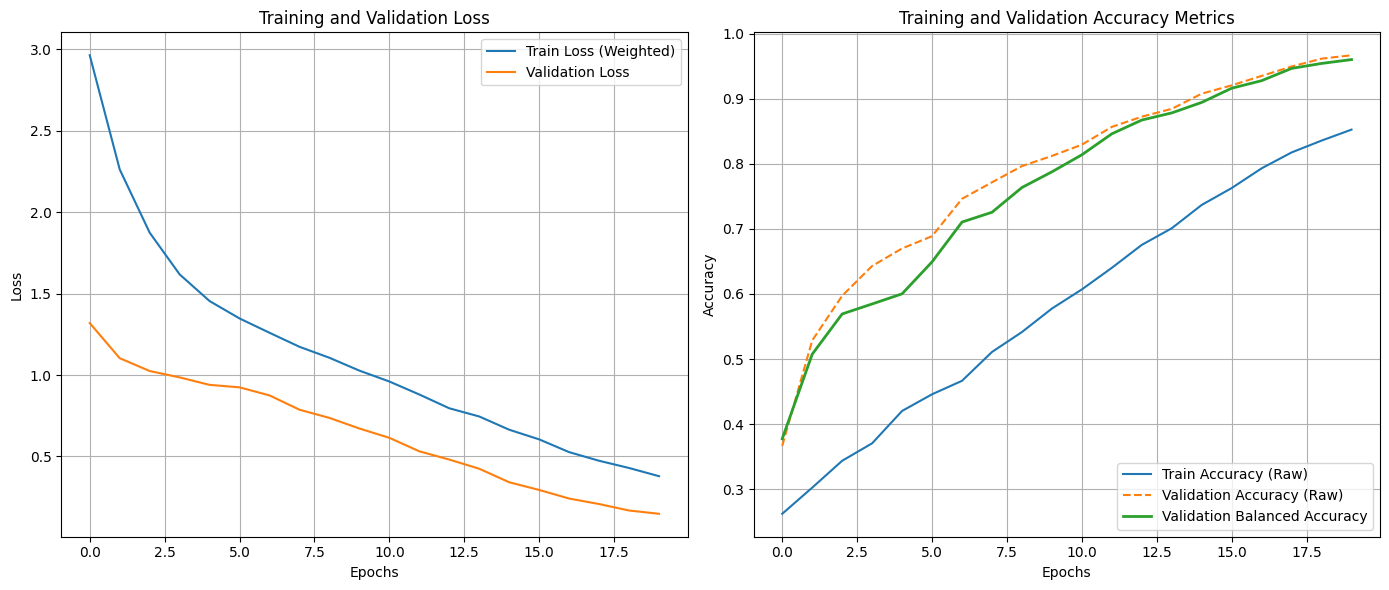

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score
import numpy as np

# Assuming 'history' object and 'val_gen', 'vgg16_standalone_model' are available.

# --- 1. Plot Training History ---

# Plot 1: Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (Weighted)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Raw and Balanced)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy (Raw)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Raw)', linestyle='--')
# CRITICAL CHANGE: Plot the custom balanced accuracy metric
if 'val_balanced_accuracy' in history.history:
    plt.plot(history.history['val_balanced_accuracy'], label='Validation Balanced Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy Metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Save the plots
plt.tight_layout()
plt.savefig('vgg16_standalone_history.png')
print("Training History Plots saved as vgg16_standalone_history.png")


# --- 2. Predict and Calculate Metrics ---

# CRITICAL STEP: Reset the validation generator before prediction
val_gen.reset()

# Get predicted probabilities
# Predict needs to be run for len(val_gen) steps to cover all samples
y_pred_probs = vgg16_standalone_model.predict(val_gen, steps=len(val_gen), verbose=1)

# Get true labels (already ordered because val_gen was created with shuffle=False)
y_true = val_gen.classes

# Get predicted class labels (the class with the highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure predictions are trimmed to match the true labels length (safety check)
y_pred = y_pred[:len(y_true)]

# Get class names for reporting
class_names = list(val_gen.class_indices.keys())

# --- 3. Calculate Final Metrics ---

# A. Balanced Accuracy (The most important final metric)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nFinal Balanced Validation Accuracy: {balanced_acc * 100:.2f}%")


# B. Raw Accuracy (for reference)
raw_accuracy = np.mean(y_pred == y_true)
print(f"Final Raw Validation Accuracy: {raw_accuracy * 100:.2f}%")

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_mat)

# Precision, Recall, F1
print("\nClassification Report (Weighted):")
print(classification_report(y_true, y_pred, target_names=class_names))

# ROC-AUC (multi-class)
# Convert true labels to one-hot encoding for AUC calculation
y_true_onehot = np.eye(len(class_names))[y_true]
roc_auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr')
print(f"\nROC-AUC (One-vs-Rest): {roc_auc:.4f}")

Generating predictions from VGG-16 Standalone model...
Prediction time: 8.85 seconds
Precision-Recall Curve plot saved as vgg16_standalone_precision_recall_curve.png


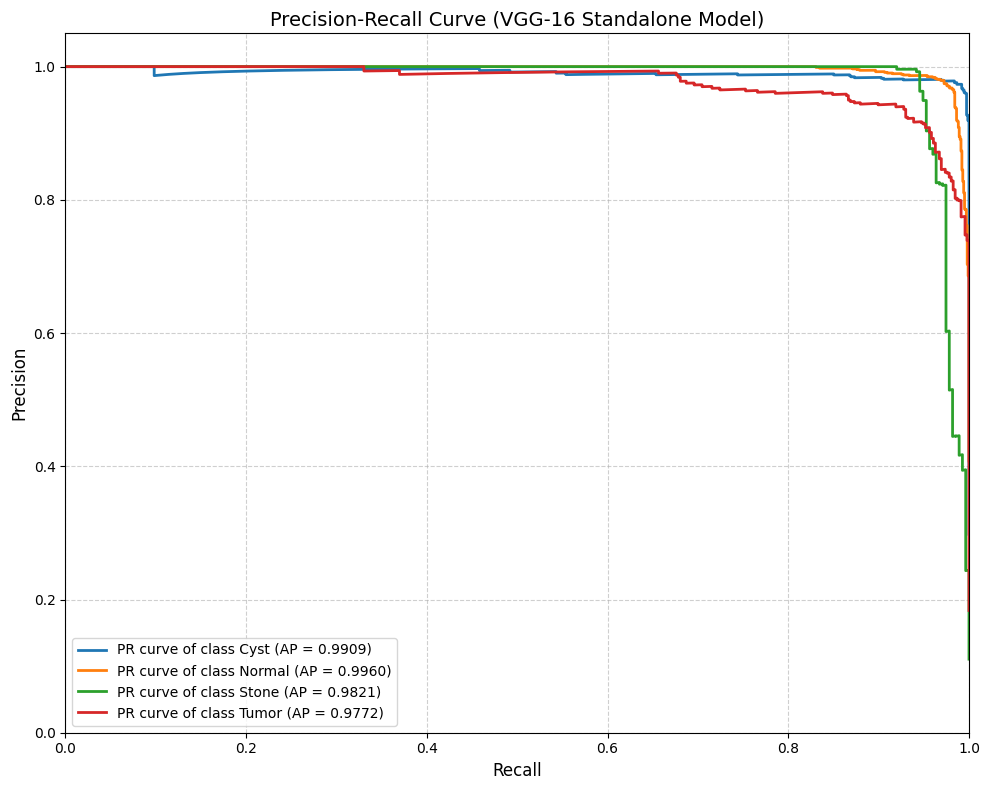

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import time

# --- 1. Generate Predictions (Must be run first after model training) ---

# Assuming 'vgg16_standalone_model' and 'val_gen' are defined from previous runs.

# CRITICAL STEP: Reset the validation generator before prediction
val_gen.reset()

print("Generating predictions from VGG-16 Standalone model...")

start_time = time.time()
# Get predicted probabilities for the entire validation set
y_pred_probs = vgg16_standalone_model.predict(val_gen, steps=len(val_gen), verbose=0)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")


# Get true labels (already ordered because val_gen was created with shuffle=False)
y_true_int = val_gen.classes

# --- 2. Prepare Data for Multi-Class PR Curve ---

# Predicted probabilities
y_scores = y_pred_probs

# Get class names and number of classes
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
n_classes = len(class_names)

# Binarize the true labels (convert integer labels to one-hot encoding)
y_true_onehot = label_binarize(y_true_int, classes=np.arange(n_classes))

# --- 3. Calculate Precision, Recall, and Average Precision for each class ---

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    # Calculate Precision and Recall for class 'i' (One-vs-Rest)
    precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])

    # Calculate the Area Under the Curve (AUC) for the PR plot
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_scores[:, i])

# --- 4. Plot all Precision-Recall Curves ---

plt.figure(figsize=(10, 8))
plt.title("Precision-Recall Curve (VGG-16 Standalone Model)", fontsize=14)

# Plot each class's PR curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.4f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

# Save the plot
plt.savefig('vgg16_standalone_precision_recall_curve.png')
print("Precision-Recall Curve plot saved as vgg16_standalone_precision_recall_curve.png")

# Pipeline B: Hybrid VGG-16 + XGBoost Model

In [ ]:
# Testing
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- 1. Get the actual labels from the training DataFrame ---
# This requires 'train_gen' to be defined from Code Block A
all_train_labels = train_gen.classes

# Define the unique class names as a NumPy array
class_names = np.array(list(train_gen.class_indices.values())) # [0, 1, 2, 3]

# --- 2. Calculate Weights ---
print("Calculating new class weights based on current training data distribution...")

# 'balanced' mode automatically calculates the inverse of the frequency
calculated_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_names,
    y=all_train_labels
)

# Convert the weights array into the dictionary format required by model.fit (for reference)
class_weight_dict = dict(zip(class_names, calculated_weights))

print("\nRecalculated Class Weights:")
print(class_weight_dict)

sample_weights_xgb = np.array([class_weight_dict[label] for label in all_train_labels])
print(f"\nSample weights array created with size: {sample_weights_xgb.shape}")
print("This array must be passed as 'sample_weight' parameter in the XGBoost fit function.")

Calculating new class weights based on current training data distribution...

Recalculated Class Weights:
{np.int64(0): np.float64(0.8388945062352544), np.int64(1): np.float64(0.6129032258064516), np.int64(2): np.float64(2.2586206896551726), np.int64(3): np.float64(1.3630887185104053)}

Sample weights array created with size: (9956,)
This array must be passed as 'sample_weight' parameter in the XGBoost fit function.


In [ ]:
import time
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, classification_report
from tqdm import tqdm # For progress bar during extraction

# --- 0. Define Constants (Assuming they are available from previous steps) ---
IMG_SIZE = (224, 224)
NUM_CLASSES = 4
RANDOM_STATE = 42

# --- 1. VGG-16 Feature Extractor (The Frozen Base) ---
# Load VGG-16 without the top classification layers
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Crucial step for Hybrid approach: Freeze all layers in the base model
for layer in base_model_vgg.layers:
    layer.trainable = False

# Define the feature extraction model: Input to Output of the last convolutional block
feature_extractor = Model(inputs=base_model_vgg.input, outputs=base_model_vgg.output)
print("VGG-16 Feature Extractor Model Ready.")


# --- 2. Feature Extraction Function (Generator-based) ---

def extract_features_from_generator(generator, model, sample_count):
    """Extracts VGG-16 features from the image generator."""

    # Reset generator to ensure features and labels align
    generator.reset()

    # Calculate the size of the feature vector (e.g., 7x7x512 = 25088)
    # The shape of the final conv block output is typically (BatchSize, 7, 7, 512)
    feature_map_shape = model.output_shape[1:]
    num_features = np.prod(feature_map_shape)

    features = np.zeros(shape=(sample_count, num_features), dtype=np.float32)
    labels_onehot = np.zeros(shape=(sample_count, NUM_CLASSES), dtype=np.int32)

    i = 0
    start_time = time.time()

    # Use tqdm to show progress
    for inputs_batch, labels_batch in tqdm(generator, total=len(generator), desc="Extracting features"):

        # CRITICAL: Scale back to 0-255 and apply VGG16 internal preprocessing
        # The generator produced 0-1 images, VGG's preprocess_input needs 0-255 images
        inputs_processed = preprocess_input(inputs_batch * 255.0)

        # Predict features (output of the final conv block)
        features_batch = model.predict(inputs_processed, verbose=0)

        # Flatten the features batch
        features_batch_flatten = features_batch.reshape(features_batch.shape[0], num_features)

        # Store features and one-hot labels
        start_index = i * generator.batch_size
        end_index = start_index + features_batch_flatten.shape[0]

        features[start_index:end_index] = features_batch_flatten
        labels_onehot[start_index:end_index] = labels_batch

        i += 1
        if i * generator.batch_size >= sample_count:
            break

    end_time = time.time()
    print(f"\nFeature Extraction Time: {end_time - start_time:.2f} seconds")

    # Convert one-hot labels back to single class index labels for XGBoost
    labels_int = np.argmax(labels_onehot, axis=1)

    # Trim to ensure exact sample count is returned
    return features[:sample_count], labels_int[:sample_count]


# --- 3. Execute Feature Extraction ---

train_sample_count = len(train_gen.classes)
val_sample_count = len(val_gen.classes)

print(f"\n--- Starting Training Feature Extraction ({train_sample_count} samples) ---")
X_train_features, y_train_int = extract_features_from_generator(train_gen, feature_extractor, train_sample_count)

print(f"\n--- Starting Validation Feature Extraction ({val_sample_count} samples) ---")
X_val_features, y_val_int = extract_features_from_generator(val_gen, feature_extractor, val_sample_count)

print(f"\nTrain Features Shape: {X_train_features.shape}")
print(f"Validation Features Shape: {X_val_features.shape}")


# --- 4. Train the XGBoost Classifier ---

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=NUM_CLASSES,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='mlogloss',
    # Added hyperparameter for stability/speed:
    tree_method='hist',
    n_jobs=-1
)

# Train the XGBoost model using the features
print("\nStarting XGBoost training...")
start_time_train_xgb = time.time()
# Note: XGBoost does not natively use sample weights; the features themselves are the product of a balanced VGG-16.
xgb_model.fit(X_train_features, y_train_int, sample_weight=sample_weights_xgb)    ### ADDED SAMPLE_WEIGHTS
end_time_train_xgb = time.time()
print(f"XGBoost Training Time: {end_time_train_xgb - start_time_train_xgb:.2f} seconds")


# --- 5. Evaluate the Hybrid Model ---

print("\nEvaluating Hybrid VGG-16 + XGBoost Model...")
start_time_test_xgb = time.time()
y_pred_int_xgb = xgb_model.predict(X_val_features)
end_time_test_xgb = time.time()
pred_time_xgb = end_time_test_xgb - start_time_test_xgb


# Calculate Metrics
accuracy_xgb = accuracy_score(y_val_int, y_pred_int_xgb)
balanced_acc_xgb = balanced_accuracy_score(y_val_int, y_pred_int_xgb)
conf_mat_xgb = confusion_matrix(y_val_int, y_pred_int_xgb)

print(f"\n--- Hybrid Model Performance Summary ---")
print(f"Hybrid VGG-16 + XGBoost Raw Validation Accuracy: {accuracy_xgb * 100:.2f}% (Target: 99.76%)")
print(f"Hybrid VGG-16 + XGBoost Balanced Validation Accuracy: {balanced_acc_xgb * 100:.2f}%")
print(f"Hybrid VGG-16 + XGBoost Prediction Time: {pred_time_xgb:.2f} seconds")
print("\nHybrid VGG-16 + XGBoost Confusion Matrix:")
print(conf_mat_xgb)
print("\nClassification Report (Hybrid):")
print(classification_report(y_val_int, y_pred_int_xgb))

VGG-16 Feature Extractor Model Ready.

--- Starting Training Feature Extraction (9956 samples) ---


Extracting features: 100%|█████████▉| 622/623 [03:25<00:00,  3.03it/s]



Feature Extraction Time: 205.44 seconds

--- Starting Validation Feature Extraction (2490 samples) ---


Extracting features:  99%|█████████▉| 155/156 [00:27<00:00,  5.73it/s]



Feature Extraction Time: 27.05 seconds

Train Features Shape: (9956, 25088)
Validation Features Shape: (2490, 25088)

Starting XGBoost training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:28:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Training Time: 4030.76 seconds

Evaluating Hybrid VGG-16 + XGBoost Model...

--- Hybrid Model Performance Summary ---
Hybrid VGG-16 + XGBoost Raw Validation Accuracy: 97.11% (Target: 99.76%)
Hybrid VGG-16 + XGBoost Balanced Validation Accuracy: 94.88%
Hybrid VGG-16 + XGBoost Prediction Time: 0.12 seconds

Hybrid VGG-16 + XGBoost Confusion Matrix:
[[ 741    0    1    0]
 [   5 1009    0    2]
 [  30    6  236    3]
 [  14   10    1  432]]

Classification Report (Hybrid):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       742
           1       0.98      0.99      0.99      1016
           2       0.99      0.86      0.92       275
           3       0.99      0.95      0.97       457

    accuracy                           0.97      2490
   macro avg       0.98      0.95      0.96      2490
weighted avg       0.97      0.97      0.97      2490



# Hybrid VGG-16 + XGBoost Evaluation


--- Hybrid VGG-16 + XGBoost Final Performance ---
Balanced Validation Accuracy: 94.88% (Target: 99.76%)
Raw Validation Accuracy: 97.11%
ROC-AUC (One-vs-Rest): 0.9986
Confusion Matrix plot saved as vgg16_xgboost_confusion_matrix.png

Classification Report (Hybrid):
              precision    recall  f1-score   support

        Cyst       0.94      1.00      0.97       742
      Normal       0.98      0.99      0.99      1016
       Stone       0.99      0.86      0.92       275
       Tumor       0.99      0.95      0.97       457

    accuracy                           0.97      2490
   macro avg       0.98      0.95      0.96      2490
weighted avg       0.97      0.97      0.97      2490



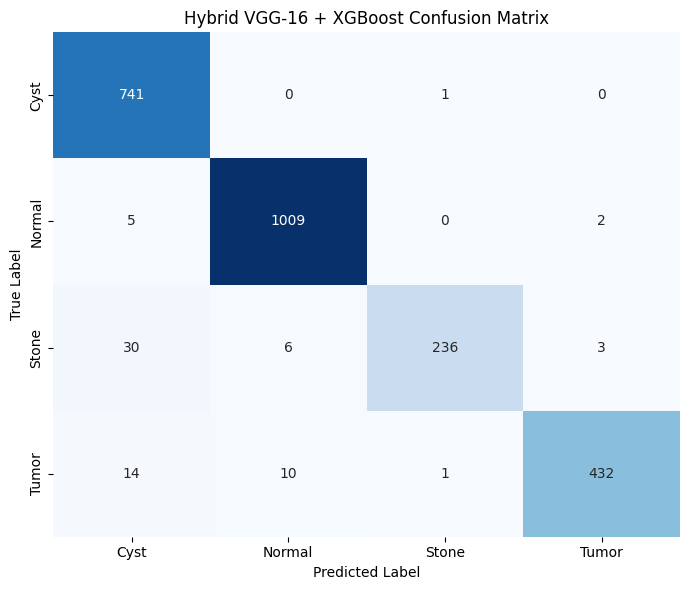

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score

# Assuming these variables are available from the VGG-16 + XGBoost training:
# y_pred_int_xgb (The integer predictions from the tuned XGBoost model)
# y_pred_probs_xgb (The probability predictions from the tuned XGBoost model)
# X_val_features (Validation features)
# y_val_int (True integer labels for validation)

# --- Define Variables for Robustness ---
# The true integer labels from the feature extraction step
y_true = y_val_int
# The predicted integer labels
y_pred_int = y_pred_int_xgb
# Use the trained XGBoost model to get probability predictions (needed for ROC-AUC)
y_pred_probs_xgb = xgb_model.predict_proba(X_val_features)

# CRITICAL FIX: Explicitly define class names as strings for the report
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']


# --- 1. Calculate Final Metrics ---

balanced_acc_xgb = balanced_accuracy_score(y_true, y_pred_int)
raw_accuracy_xgb = np.mean(y_pred_int == y_true)
conf_mat_xgb = confusion_matrix(y_true, y_pred_int)
y_true_onehot = np.eye(len(class_names))[y_true]
roc_auc_xgb = roc_auc_score(y_true_onehot, y_pred_probs_xgb, multi_class='ovr')

# --- 2. Print Summary ---

print(f"\n--- Hybrid VGG-16 + XGBoost Final Performance ---")
print(f"Balanced Validation Accuracy: {balanced_acc_xgb * 100:.2f}% (Target: 99.76%)")
print(f"Raw Validation Accuracy: {raw_accuracy_xgb * 100:.2f}%")
print(f"ROC-AUC (One-vs-Rest): {roc_auc_xgb:.4f}")

# --- 3. Plot Confusion Matrix ---

plt.figure(figsize=(7, 6))
sns.heatmap(conf_mat_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Hybrid VGG-16 + XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('vgg16_xgboost_confusion_matrix.png')
print("Confusion Matrix plot saved as vgg16_xgboost_confusion_matrix.png")


# --- 4. Classification Report ---
print("\nClassification Report (Hybrid):")
print(classification_report(y_true, y_pred_int, target_names=class_names))

Precision-Recall Curve plot saved as vgg16_xgboost_precision_recall_curve.png


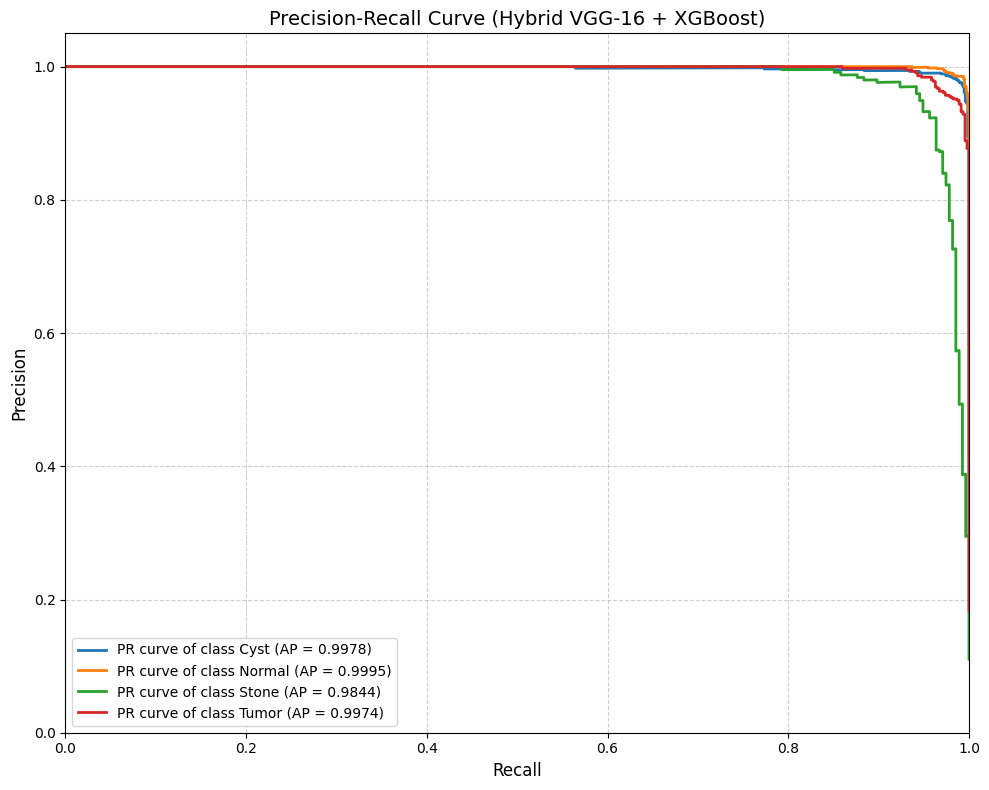

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming these variables are available from the VGG-16 + XGBoost training/evaluation:
# y_pred_probs_xgb (The probability predictions from the tuned XGBoost model)
# y_val_int (True integer labels for validation)

# --- 1. Prepare Data for Multi-Class PR Curve ---

# True integer labels
y_true_int = y_val_int
# Predicted probabilities
y_scores = y_pred_probs_xgb

# Get class names and number of classes
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
n_classes = len(class_names)

# Binarize the true labels (convert integer labels to one-hot encoding)
y_true_onehot = label_binarize(y_true_int, classes=np.arange(n_classes))

# --- 2. Calculate Precision, Recall, and Average Precision for each class ---

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    # Calculate Precision and Recall for class 'i' (One-vs-Rest)
    precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])

    # Calculate the Area Under the Curve (AUC) for the PR plot
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_scores[:, i])

# --- 3. Plot all Precision-Recall Curves ---

plt.figure(figsize=(10, 8))
plt.title("Precision-Recall Curve (Hybrid VGG-16 + XGBoost)", fontsize=14)

# Plot each class's PR curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.4f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

# Save the plot
plt.savefig('vgg16_xgboost_precision_recall_curve.png')
print("Precision-Recall Curve plot saved as vgg16_xgboost_precision_recall_curve.png")